<a href="https://colab.research.google.com/github/juliana-zh/machine_learning/blob/main/House_prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Проект "Цены на дома"

**Цель**: по заданным признакам предсказать цены на дома.

Проект на платформе Kaggle: https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview

**План**:
1. Понимание задачи. Посмотреть на признаки, понять, что они означают и сделать первоначальное предположение о важности для решения этой задачи
2. Одномерный анализ. Мы сфокусируемся на зависимом признаке ('SalePrice') и попробуем узнать немного больше о нем.
3. Многомерный анализ. Мы попытаемся понять, как зависимые и независимые признаки связаны друг с другом.
4. Обработка пропусков, выбросов и категориальных признаков.
5. Проверка предположений

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
%matplotlib inline

In [ ]:
df_train = pd.read_csv('https://raw.githubusercontent.com/juliana-zh/machine_learning/main/datasets/house_prices/train.csv')

In [ ]:
df_train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

## 1. Понимание задачи

Лучше будет посмотреть на признаки нашего датасета, понять, что они означают и попробовать сначала прикинуть, какие из признаков оказывают большее влияние на проблему.

Например, можно было бы расписать для каждого из признаков такую информацию:
- имя признака
- тип признака (численный или категориальный)
- к какой группе по смыслу относится: например: 1) площадь 2) качество 3) локация
- ожидания: какое влияние этот нецелевой признак оказывает на целевой признак (можно использовать категории: низкое, среднее, высокое)
- вывод: какое влияние этот нецелевой признак оказывает на целевой признак исходя из наших наблюдений за данными
- комментрии

Колонка "Ожидания" важна, и можно было бы попытаться развить навык оценки путем использования следующих вопросов:
- думаем ли мы об этом признаке, когда собираемся приобрести дом?
- какая степень влияния этого признака на наше решение?
- включена ли информация об этом признаке в какой-то другой признак. Пример: число машин в гараже и общая площадь гаража, площадь фундамента и площадь первого этажа

После того, как мы продумали все это, берем признаки с высоким ожиданием и строим scatter-график зависимости этих признаков и целевого (здесь 'SalePrice'). Далее мы можем по итогам сделать поправки относительно наших ожиданий в пункте "вывод".





Все переменные указаны тут: https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data

Предположим, мы изучили данные и наделили некоторые из признаков высоким ожиданием относительно влияния на целевой признак. Пусть в данном случае мы выделили:

- OverallQual - общее качество строения
- YearBuilt - год постройки
- TotalBsmtSF - общая площадь фундамента
- GrLivArea - общая жилищная площадь (над фундаментом)

Насчет групп признаков: два из них относятся к группе характеристик здания (OverallQual и YearBuilt), два из них - к группе пространства (TotalBsmtSF, GrLivArea)

Отметим, что box plots более удобны для визуализации категориальных признаков

## 2. Одномерный анализ

In [ ]:
df_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

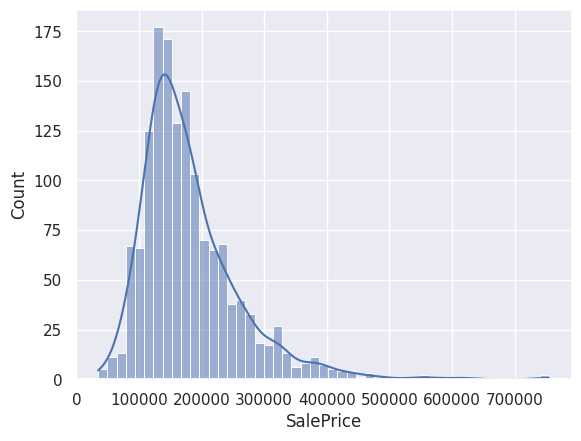

In [ ]:
sns.histplot(df_train['SalePrice'], kde=True);

Что мы видим?
- график отклонен от нормального распределения
- положительная ассиметрия (positive skewness) - когда хвост распределения справа длиннее, чем слева
- видимый пик

In [ ]:
print("Skewness: %f" % df_train['SalePrice'].skew())
print("Kurtosis: %f" % df_train['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


Kurtosis - величина, показывающая то, насколько график имеет длинный хвост. Это зависит от того, насколько много у нас выбросов.

### Относительно численных признаков

In [ ]:
var = 'GrLivArea'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)

<Axes: xlabel='GrLivArea', ylabel='SalePrice'>

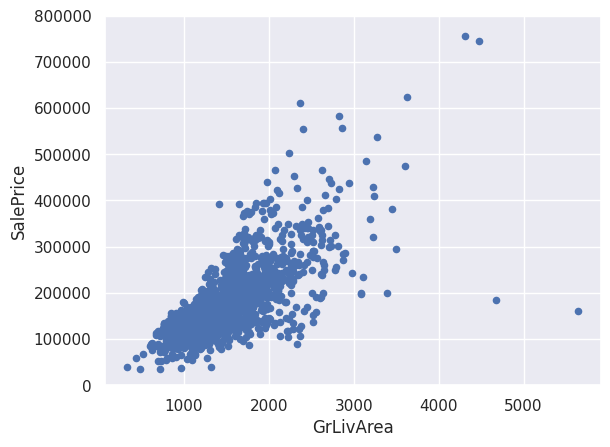

In [ ]:
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000))

Похоже, что между признаком 'GrLivArea' и признаком 'SalePrice' есть линейная зависимость

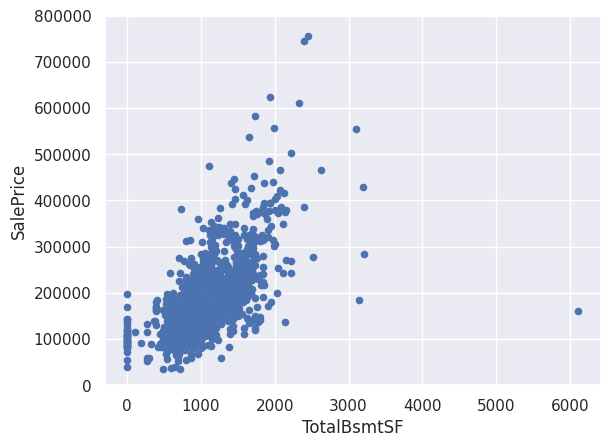

In [ ]:
var = 'TotalBsmtSF'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

Линейная (возможно и экспоненциальная) зависимость

### Относительно категориальных признаков

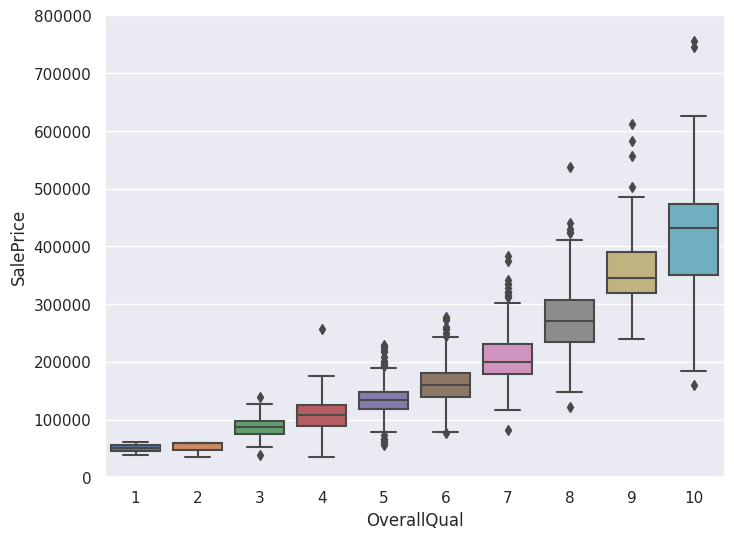

In [ ]:
var = 'OverallQual'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

Мы видим, что есть зависимость между признаком 'OverallQual' и признаком 'SalePrice'

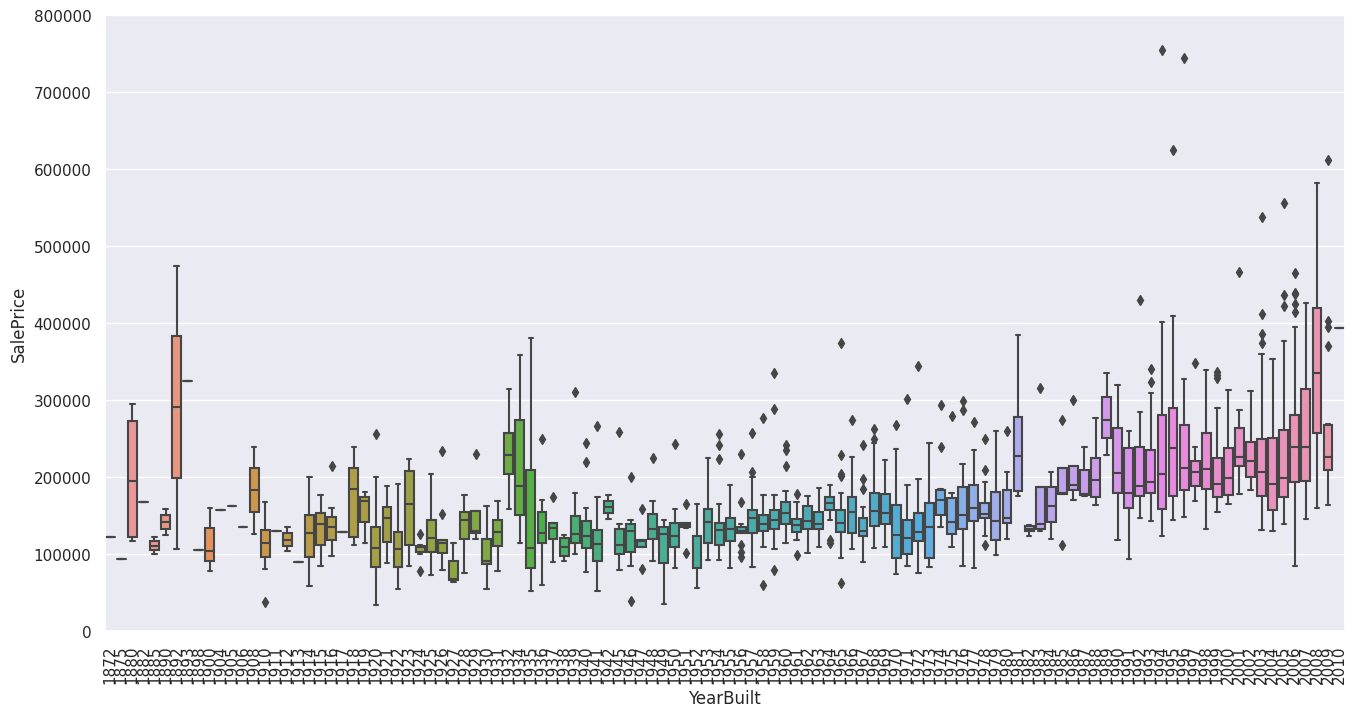

In [ ]:
var = 'YearBuilt'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=90);

Видим, что все-таки есть тенденция, пусть и небольшая, к тому, чтобы признак 'SalePrice' принимал более высокие значения на более новых постройках

**Выводы**:

 1. Нецелевые численные признаки 'GrLivArea' и 'TotalBsmtSF' скорее всего, линейно связаны с целевым признаком 'SalePrice', причем угол наклона 'TotalBsmtSF' больше. Обе связи положительные (при росте значения аргумента растет значение функции)

 2. Нецелевые категориальные признаки 'OverallQual' и 'YearBuilt' скорее всего, тоже связаны с целевым признаком 'SalePrice'. Причем, связь сильнее в случае признака 'OverallQual'.

## 3. Многомерный анализ

**План**

- корреляционная матрица в целом (heatmap)
- корреляционная матрица для целевого параметра 'SalePrice' и некоторых нецелевых признаков
- точечные графики между отобранными признаками


#### Общая корреляционная матрица

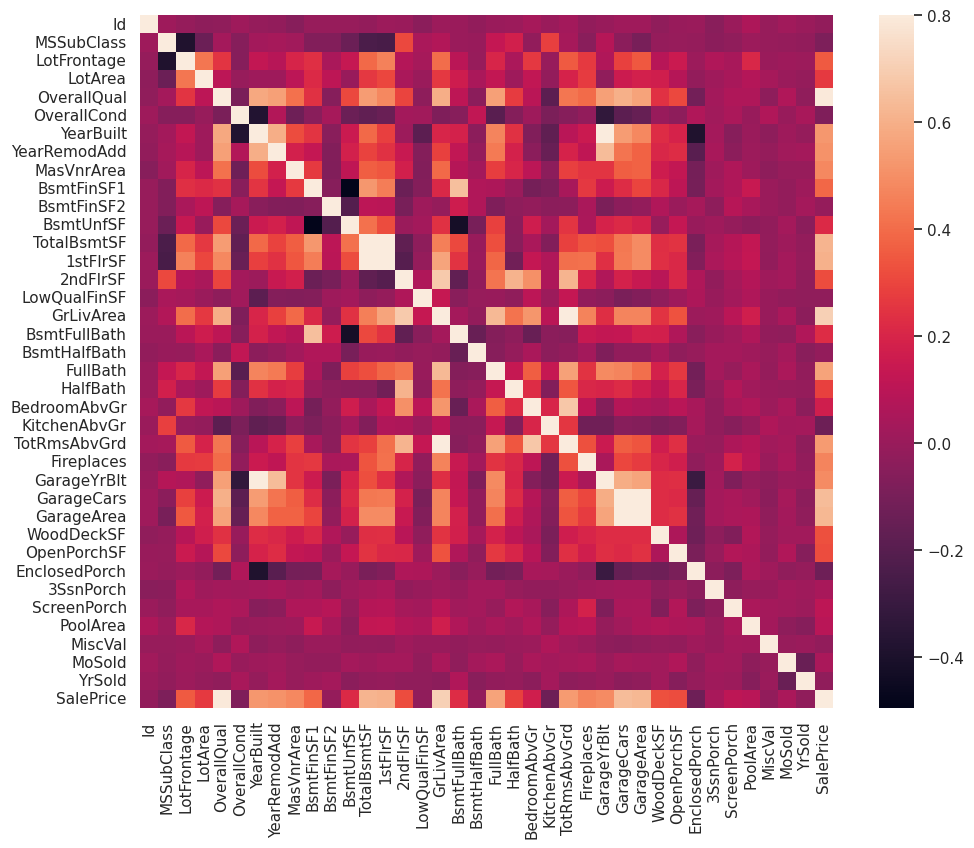

In [ ]:
corrmat = df_train.corr(numeric_only=True)
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

Заметим, что есть белый квадратик на пересечении признаков 'TotalBsmtSF' и '1stFlrSF'. И есть квадратик на пересечении признаков 'GarageCars' и 'GarageArea'. Белый цвет - очень высокая корреляция. Скорее всего, речь идет о мультиколлинеарности.

Далее посмотрим, какие нецелевые признаки больше всего коррелируют с целевым признаком 'SalePrice'. Мы видим уже знакомые нам 'GrLivArea', 'TotalBsmtSF' и 'OverallQual', а также и другие нецелевые признаки светлого цвета, а это значит, их тоже следует принять в рассмотрение. Следующим шагом сделаем это.

#### Корреляционная матрица для 'SalePrice' и некоторых отобранных нецелевых признаков

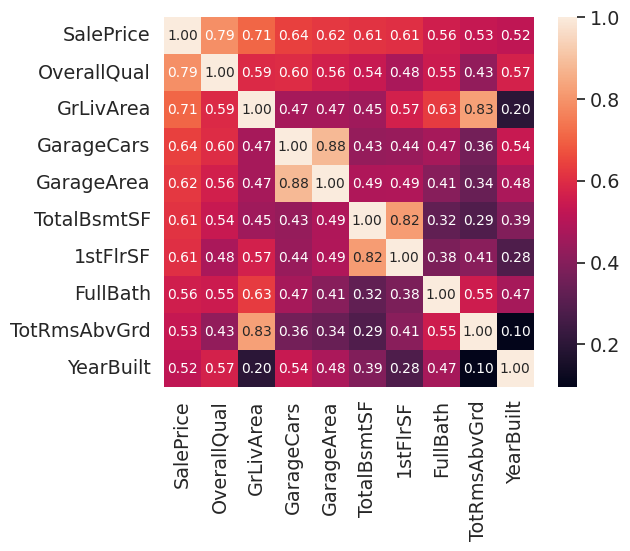

In [ ]:
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

Мы видим следующее:
- нецелевые признаки 'OverallQual', 'GrLivArea' and 'TotalBsmtSF' сильно коррелируют с целевым признаком 'SalePrice', как мы до этого и предполагали
- прзнаки 'GarageCars' и 'GarageArea' обладают очень сильной корреляцией. Один из признаков можно убрать без значительной потери информации. Оставить лучше 'GarageCars', так как у него сильнее влияние на целевой признак 'SalePrice'
- аналогичная ситуация и с признаками 'TotalBsmtSF' и '1stFlrSF'. Оставляем, например, этот:  'TotalBsmtSF'
- видим, что признак 'FullBath' коррелирует с целевым признаком 'SalePrice'
- можем заметить также, что есть корреляция между нецелевыми признаками: 'GrLivArea' и 'TotRmsAbvGrd', оставляем 'GrLivArea'
- 'YearBuild' слегка коррелирует с 'SalePrice'

#### Точечные графики между отобранными признаками

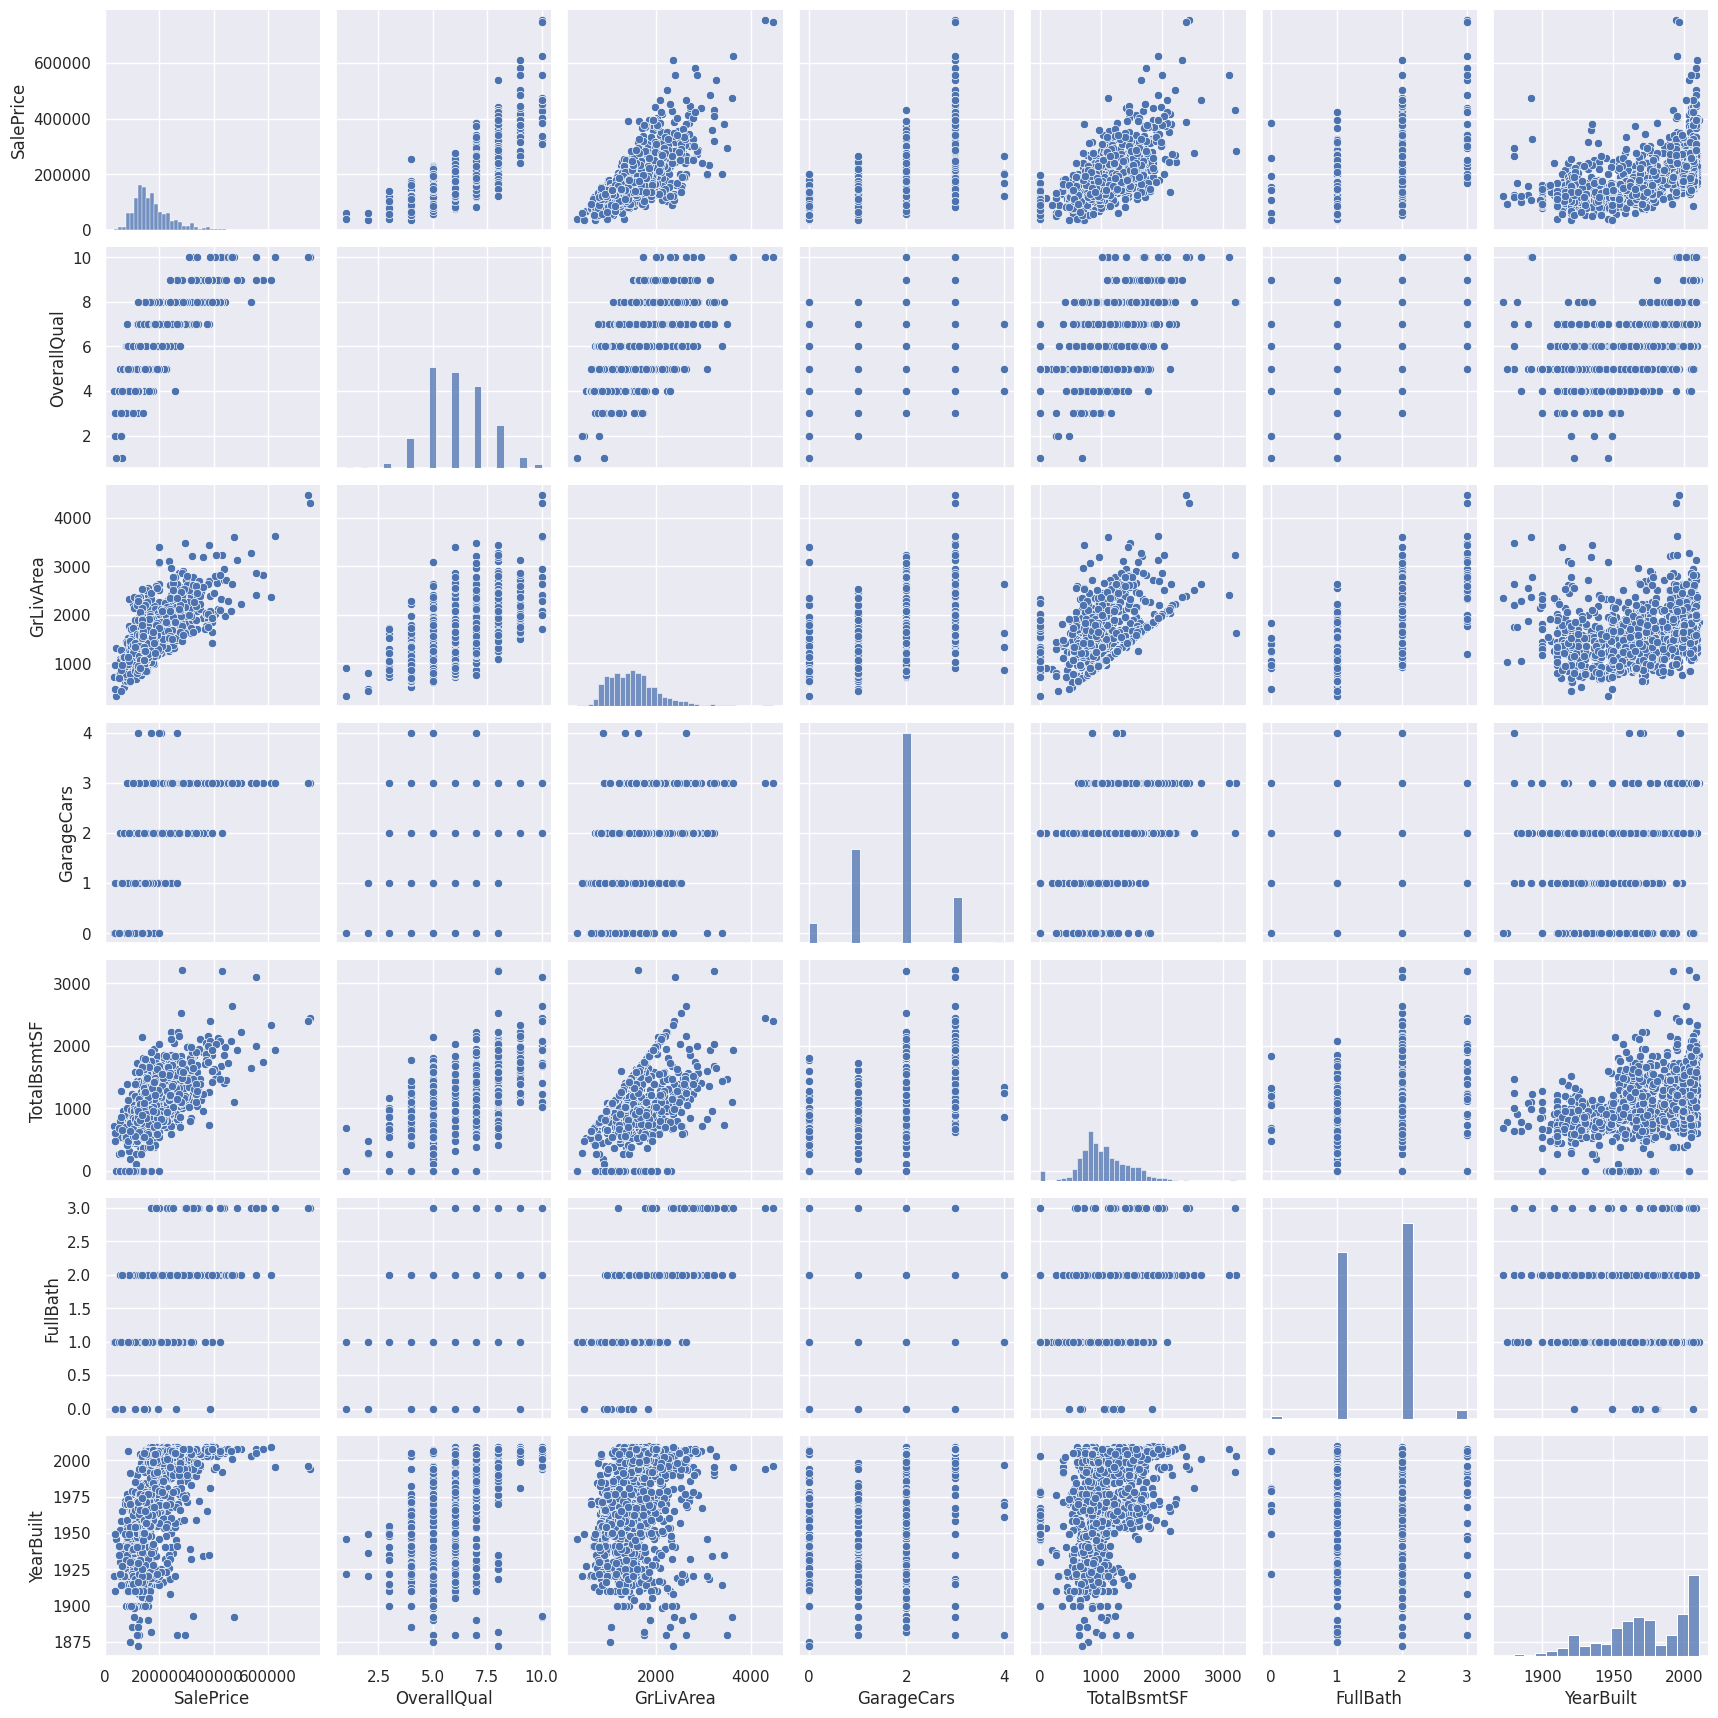

In [ ]:
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(df_train[cols], height = 2.5)
plt.show();

Помним, что на диагонали находятся графики распределения признаков.

Интересным является график между  'TotalBsmtSF' and 'GrLiveArea'. Можно обнаружить, что точки формируют линию, которая является почти барьером.
Этому есть разумное объяснение: фундамент обычно меньше жилплощади 1-ого этажа.

График 'YearBuilt' и 'SalePrice'. Нижняя граница точек ведет себя как экспоненциальная функция, верхняя граница тоже. А если глянуть на последние годы, там видно, что немалое количество точек находится сильно выше верхней границы

## 4. Обработка пропусков, выбросов и категориальных признаков

### Пропуски

Вопросы о данных, которые нам следует задать:

- насколько много у нас пропущенных данных?
- можем ли мы выделить какой-то паттерн в пропусках или пробелы в данных нам кажутся случайными?

Это важные вопросы, так как простое удаление может повлиять на качество нашего анализа. Также нам следует убедиться, что пропущенные данные не являются следствием ангажированности, предубеждения, сокрытия неприятной правды.

In [ ]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.shape[0]).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
GarageCond,81,0.055479
GarageType,81,0.055479
GarageFinish,81,0.055479


Мы примем такое утверждение: "Удаляем любой нецелевой признак, у которого пропусков > 15%". В данном случае это будут 'PoolQC', 'MiscFeature', 'Alley'.

Кроме того, можно заметить, что признаки GarageX имеют одинаковое количество пропусков. Так как наиболее важная информация относительно гаражей выражена в переменной 'GarageCars', оставляем ее.

Аналогично поступаем с признаками 'Bsmt*'

Относительно признаков 'MasVnrArea' и 'MasVnrType'. 'MasVnrArea' коррелирует с  'YearBuilt' and 'OverallQual'. Удаляем 'MasVnrArea' и 'MasVnrType'.

И мы видим всего лишь одно пропущенное значение у признака 'Electrical'. Удалим данное наблюдение при сохранении других наблюдений этого признака.

In [ ]:
df_train = df_train.drop((missing_data[missing_data['Total'] > 1]).index, axis = 1)
df_train = df_train.drop(df_train.loc[df_train['Electrical'].isnull()].index)
df_train.isnull().sum().max() #just checking that there's no missing data missing...

0

### Выбросы

Нам следует быть внимательными относительно выбросов. Они могут повлиять на предсказания нашей модели, а также служить источниками ценной информации о неспецифичном поведении, способствуя появлению новых идей.

#### Одномерный анализ

Здесь нам нужно установить порог, при превышении которого объект будет считаться выбросом. Для этого мы сначала нормализуем данные. В данном случае это означает приведение их к такому виду, что среднее значение = 0, а  среднеквадратичное отклонение = 1.

In [ ]:
saleprice_scaled = StandardScaler().fit_transform(df_train['SalePrice'][:,np.newaxis]);
low_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][:10]
high_range= saleprice_scaled[saleprice_scaled[:,0].argsort()][-10:]
print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)

outer range (low) of the distribution:
[[-1.83820775]
 [-1.83303414]
 [-1.80044422]
 [-1.78282123]
 [-1.77400974]
 [-1.62295562]
 [-1.6166617 ]
 [-1.58519209]
 [-1.58519209]
 [-1.57269236]]

outer range (high) of the distribution:
[[3.82758058]
 [4.0395221 ]
 [4.49473628]
 [4.70872962]
 [4.728631  ]
 [5.06034585]
 [5.42191907]
 [5.58987866]
 [7.10041987]
 [7.22629831]]


<ipython-input-54-c710db20a36e>:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  saleprice_scaled = StandardScaler().fit_transform(df_train['SalePrice'][:,np.newaxis]);


Мы получили 10 минимальных и максимальных значений:

- минимальные значения находятся недалеко от нуля
- максимальные значения далеки от нуля, притом что два из них (7.10041987 и 7.22629831) находятся совсем далеко

На данный момент времени анализа мы пока не будем торопиться относить какие-либо из них к выбросам.

#### Двумерный анализ

Рассмотрим еще раз график с признаками 'GrLivArea' и 'SalePrice':

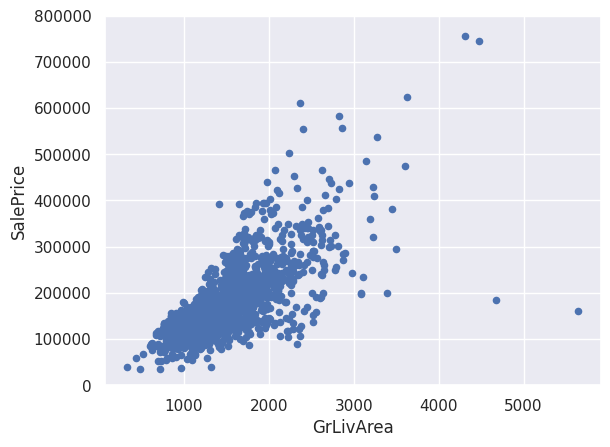

In [ ]:
var = 'GrLivArea'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

Что обнаруживаем:

- Два значения с большим 'GrLivArea' кажутся странными, они находятся в отдалении. Можно попробовать предположить, почему так происходит. Возможно, они относятся к сельскохозяйственному району, и это могло бы объяснить низкую цену. Эти два момента не являются репрезентативными для типичного случая. Поэтому мы определим их как выбросы и удалим их.
- Два наблюдения в верхней части графика - это те наблюдения (7.10041987 и 7.22629831), которые упоминались ранее. Они выглядят как два особых случая, однако, похоже, следуют тенденции. По этой причине мы сохраним их.

In [ ]:
df_train.sort_values(by = 'GrLivArea', ascending = False)[:2]

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1298,1299,60,RL,63887,Pave,IR3,Bnk,AllPub,Corner,Gtl,...,0,0,0,480,0,1,2008,New,Partial,160000
523,524,60,RL,40094,Pave,IR1,Bnk,AllPub,Inside,Gtl,...,0,0,0,0,0,10,2007,New,Partial,184750


In [ ]:
df_train = df_train.drop(df_train[df_train['Id'] == 1299].index)
df_train = df_train.drop(df_train[df_train['Id'] == 524].index)

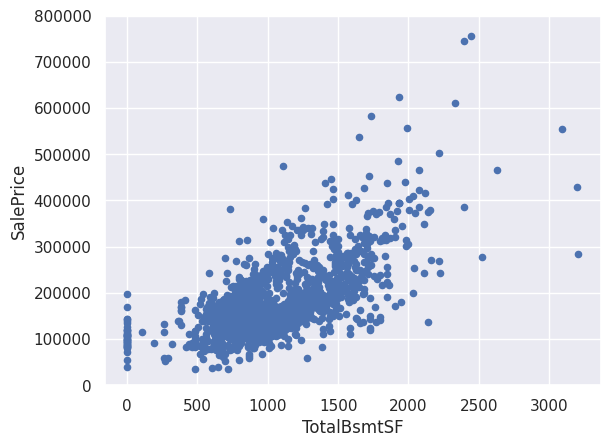

In [ ]:
var = 'TotalBsmtSF'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

Мы можем испытывать искушение исключить некоторые наблюдения (например, те, где значение признака 'TotalBsmtSF' > 3000), но возможно, оно того не стоит.

## 5. Проверка предположений

Наша цель: потестировать целевой признак 'SalePrice' на следующие аспекты:

- **Гистограмма** - коэффициент эксцесса (kurtosis) и асимметрия (skewness).
- **Функция нормального распределения** - распределение данных должно в значительной степени соответствовать диагонали, представляющей нормальное распределение.

In [73]:
import warnings
warnings.filterwarnings('ignore')

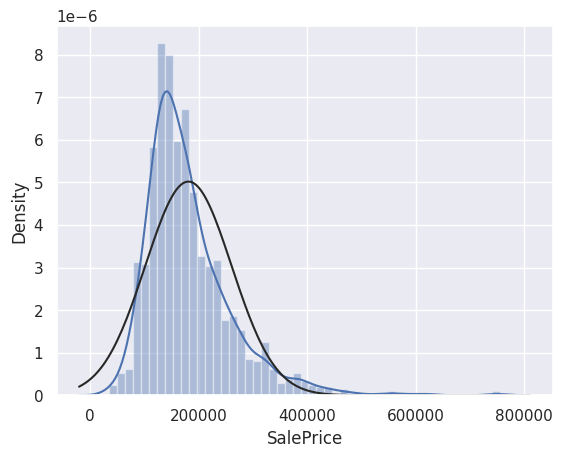

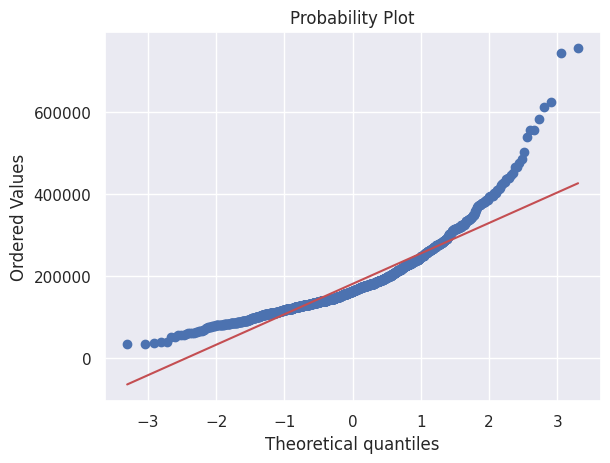

In [74]:
sns.distplot(df_train['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)

In [ ]:
warnings.filterwarnings('default')